# Q5
We first define the data generating process for the linear IV model. 

In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import distributions as iid
import statsmodels.api as sm
from matplotlib import pyplot as plt 

def dgp(N, beta, pi): 
    '''
    Data generating process 
    
    Input: 
    N    : # of obs 
    beta : true coefficient of x on y, scalar 
    pi   : true coefficient of Z on x, lx1 vector 
    
    Output: y, x, Z (Nxl)
    
    Assume that the residuals in both stages follow standard normal distribution and are independent. 
    '''
    l = len(pi) 
    u = iid.norm().rvs(N)
    v = iid.norm().rvs(N)
    Z = np.random.normal(size=N*l).reshape(N, l) 
    x = Z@pi + v 
    y = beta*x + u 
    return (y, x, Z)

## (1)
Here we write a function which takes as arguments $(y, x, Z, \beta_0)$ and returns the $p$-value associated with the hypothesis that each of the $l$ elements of $\hat \gamma$ is zero (with an F-test). 

In [2]:
def p_val(y, x, Z, beta0): 
    '''
    Compute p-value from an F test on \gamma = 0 
    
    Input: y, x, Z, beta0 (guess of true beta)
    
    Ouput: p-value 
    '''
    yh = y - beta0*x # transform the LHS var
    lm = sm.OLS(yh, Z).fit() # fit the linear model 
    return lm.f_pvalue # return p value from F test

## (2)
To estimate $\beta$, we start by trying possible values within $[0, 2]$ range (since we know the true $\beta = 1$). The following function returns the estimated $\beta_0$ and corresponding maximal p-value. 

In [48]:
def max_p(y, x, Z):
    '''
    Obtain the estimate beta0 that max p-value 
    
    Input: y, x, Z 
    
    Output: beta0, max p-value 
    '''
    beta_lst = list(np.arange(0, 2, 0.001)) # Try beta0 in this range 
    p_lst = [] 
    
    for i in range(len(beta_lst)): # get p-value for each corresponding beta0
        p_lst.append(p_val(y, x, Z, beta_lst[i])) 
    p_dict = dict(zip(beta_lst, p_lst))
    
    max_beta = max(p_dict, key=p_dict.get)
    max_pval = p_dict[max_beta] # maxinmal pval and beta 
    
    ci_beta = list(dict(filter(lambda item: item[1]>=0.05, p_dict.items())).keys()) 
    ci = [ci_beta[0], ci_beta[-1]] # confidence interval 
    
    return max_beta, max_pval, ci

Taking $\pi=1$, we can estimate $\beta$ as follows. 

In [54]:
# True parameters 
N, beta, pi = 1000, 1, [1]

y, x, Z = dgp(N, beta, pi) # DGP, no set seed so each time the results will be a bit different 

b, pval, ci = max_p(y, x, Z) # estimate beta
print(f'The estimated coefficient is {b}, the corresponding maximal p-value is {pval}')

The estimated coefficient is 1.033, the corresponding maximal p-value is 0.9931414596456031


To assess the bias and precision of this estimator, we draw 1,000 random samples and plot the distribution of estiamtes. 

<function matplotlib.pyplot.show(close=None, block=None)>

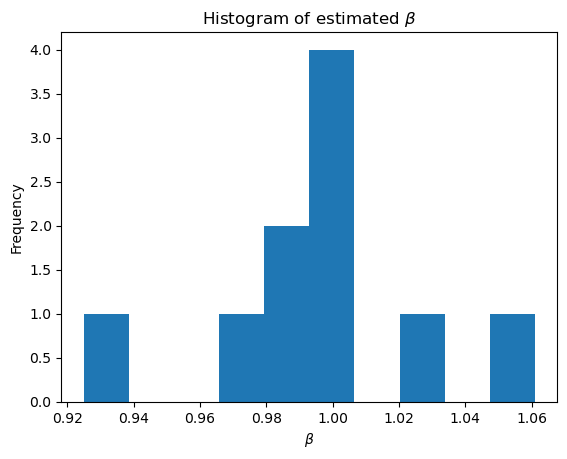

In [8]:
####### WARNING: This chunk will take forever to run 
it = 0 
b_lst = []
while it < 10: 
    y, x, Z = dgp(N, beta, pi)
    b_lst.append(max_p(y, x, Z)[0])
    it = it + 1

plt.hist(pd.DataFrame(b_lst), )
plt.title(r'Histogram of estimated $\beta_0$')
plt.xlabel(r'$\beta_0$')
plt.ylabel('Frequency')
plt.show

As illustrated in the figure above, the estimator seems to be quite unbiased in expectation. Bias or deviation in a specific sample is also small, so overall it is quite precise. 

## (3)
The null hypothesis of our F test is that $\hat \gamma = 0$, which corresponds to $\beta = \beta_0$. Intuitively, to construct a 95% confidence interval on $\beta_0$, we need the p-value to be greater than or equal to 0.05 so that we cannot reject the null. The construction of confidence interval is incorporated into the 'max_p' function above. Below is another estimate from a specific sample. 

In [55]:
# True parameters 
N, beta, pi = 1000, 1, [1]

y, x, Z = dgp(N, beta, pi) # DGP  

b, pval, ci = max_p(y, x, Z) # estimate beta
print(f'The estimated coefficient is {b}, the corresponding maximal p-value is {pval}, and confidence interval is {ci}')

The estimated coefficient is 1.0030000000000001, the corresponding maximal p-value is 0.9884396909953668, and confidence interval is [0.937, 1.068]


The 95% confidence interval from 2SLS can be obtained as follows. As a comparison... 

In [56]:
# NB: need code from Q4 to get 2SLS estimate 

## (4)
As $\pi$ goes from 1 toward zero, the estimate becomes biased and much less precise. 

In [57]:
# True parameters 
N, beta, pi = 1000, 1, [0]

y, x, Z = dgp(N, beta, pi) # DGP  

b, pval, ci = max_p(y, x, Z) # estimate beta
print(f'The estimated coefficient is {b}, the corresponding maximal p-value is {pval}, and confidence interval is {ci}')

The estimated coefficient is 0.764, the corresponding maximal p-value is 0.9995219017241671, and confidence interval is [0.0, 1.6640000000000001]


## (5) 
How does the coverage of your test change as $l$ grows large? Compare with 2SLS. 